# Fragment library

## Aim of this notebook

From the subpocket-based fragment pools (SDF files), create one DataFrame holding all fragment data (including a column for the fragments' subpocket as wells as both SMILES with and without dummy atoms).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools

import klifs_utils
from util import read_fragment_library

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
PATH_DATA = Path('.') / '..' / 'data' / 'fragment_library'
PATH_DATA.mkdir(parents=True, exist_ok=True)

## Load fragment library

`fragment_library_wo_dummy` and `fragment_library_w_dummy` are dictionaries of fragments (values) per subpocket (keys) without and with dummy atoms. In the former case, dummy atoms were replace with hydrogen atoms.

The following data is linked to each fragment:

- *PDB complex* and *ligand ID*, *alternate model* and *chain* for the structure that the ligand (from which the fragment originates) was co-crystallized with (data from [KLIFS](https://klifs.vu-compmedchem.nl/index.php)) 
- *Kinase* name, *family* and *group* of the kinase the ligand (from which the fragment originates) was co-crystallized with
- *Subpocket* occupied by the fragment
- Subpockets for each of the fragment's atoms (including the dummy atom's subpockets which show the connection of the fragment to neighboring pockets, column: *atom_subpockets*)
- BRICS environment IDs for each of the fragment's atoms (column: *atom_environments*)
- Fragment's *RDKit molecule* (remote KLIFS access) and *SMILES* (generated from RDKit molecule)

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])
Example fragments for subpocket AP:


,ROMol,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles
0,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12
1,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1

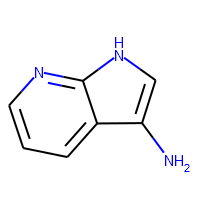
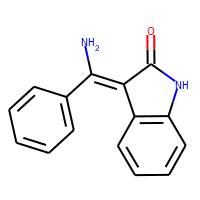

In [5]:
# Get fragment library by subpocket
fragment_library_wo_dummy = read_fragment_library(PATH_DATA)

print(fragment_library_wo_dummy.keys())
print(f'Example fragments for subpocket AP:')
fragment_library_wo_dummy['AP'].head(2)

In [6]:
# Get fragment library by subpocket with dummy atoms
fragment_library_w_dummy = read_fragment_library(PATH_DATA, remove_dummy=False)

## Concatenate all subpocket pools to one DataFrame

In [7]:
def concatenate_subpocket_pools(fragment_library):
    """
    Concatenate subpocket pools of fragments to one DataFrame with all fragments.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Dictionary of fragments (values = DataFrames) per subpocket (keys).
    
    Returns
    -------
    fragment_library_concat : pandas.DataFrame
        Fragment library in one DataFrame.
    """

    # Add subpocket column
    for subpocket, fragments in fragment_library.items():
        
        try:
            fragments.insert(8, 'subpocket', subpocket)
        except ValueError:
            pass

    # Concatenate dictionary values (i.e. DataFrames)
    fragment_library_concat = pd.concat(fragment_library)
    
    # Reset index
    fragment_library_concat.reset_index(drop=True, inplace=True)
    
    return fragment_library_concat

In [8]:
fragment_library_wo_dummy_concat = concatenate_subpocket_pools(fragment_library_wo_dummy)
fragment_library_wo_dummy_concat.shape

(7486, 12)

In [9]:
fragment_library_w_dummy_concat = concatenate_subpocket_pools(fragment_library_w_dummy)
fragment_library_w_dummy_concat.shape

(7486, 12)

## Merge data frames: Fragment info with and without dummy atoms

(7486, 13)


,ROMol,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,subpocket,atom_subpockets,atom_environments,smiles,smiles_dummy_atoms
0,,AAK1,NAK,Other,5l4q,LKB,B,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1
1,,AAK1,NAK,Other,5te0,XIN,,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1
2,,ABL1,Abl,TK,2f4j,VX6,,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,Cc1cc(N)[nH]n1,[22*]Nc1cc(C)n[nH]1
3,,ABL1,Abl,TK,2gqg,1N1,B,A,AP,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,Nc1ncc(C=O)s1,[15*]Nc1ncc(C([41*])=O)s1
4,,ABL1,Abl,TK,2v7a,627,,B,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12

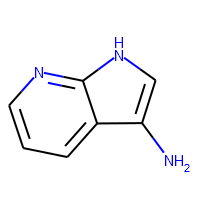
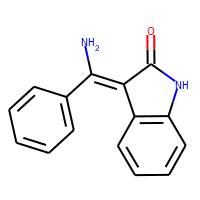
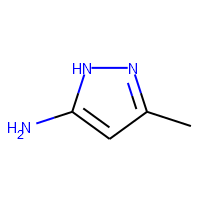
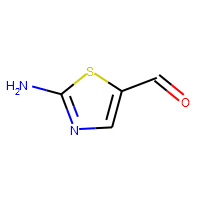
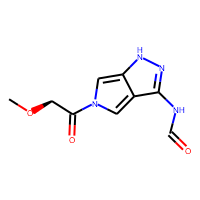

In [10]:
fragment_library_concat = fragment_library_wo_dummy_concat.copy()
fragment_library_concat['smiles_dummy_atoms'] = fragment_library_w_dummy_concat.smiles
print(fragment_library_concat.shape)
fragment_library_concat.head()

## Save concatenated fragment library

In [11]:
fragment_library_concat.drop('ROMol', axis=1).to_csv(PATH_DATA / 'fragment_library.csv', index=False)